# Example Notebook for plotting insitu data

In [1]:
%load_ext autoreload

%autoreload 2

import datetime as datetime
import numpy as np
import py3dcore_h4c as py3dcore_h4c
import matplotlib.pyplot as plt

In [2]:
###### overwrite initial values that we already know or can estimate more closely

overwrite = {
    "cme_longitude": {
            "maximum": 180,
            "minimum": 175
        },
    "cme_latitude": {
            "maximum": -9,
            "minimum": -10
        },
    "cme_inclination" :{
            "maximum": 0.7,
            "minimum": 0.5
        },
    "cme_diameter_1au" :{
            "maximum": 0.4,
            "minimum": 0.3
        },
    "cme_aspect_ratio": {
            "maximum": 1.5,
            "minimum": 1
        },
    "cme_launch_radius": {
            "maximum": 15.0,
            "minimum": 14.3
        },
    "cme_launch_velocity": {
            "maximum": 1950,
            "minimum": 1850
        },
    "t_factor": {
            "maximum": 170,
            "minimum": 150
        },
    "magnetic_field_strength_1au": {
            "maximum": 29,
            "minimum": 28
        },
    "background_drag": {
            "maximum": 1.65,
            "minimum": 1.5
        },
    "background_velocity": {
            "maximum": 675,
            "minimum": 600
        },
}


# initialize model

n = 1024 # number of runs
# start = datetime.datetime.now() # starttime of ICME
start = datetime.datetime(2022, 9, 5, 18, 45, 0)

model_obj = py3dcore_h4c.ToroidalModel(start, n, iparams=overwrite)

    Model Parameters
    ================
        For this specific model there are a total of 14 initial parameters which are as follows:
        0: t_i          time offset
        1: lon          longitude
        2: lat          latitude
        3: inc          inclination

        4: dia          cross section diameter at 1 AU
        5: delta        cross section aspect ratio

        6: r0           initial cme radius
        7: v0           initial cme velocity
        8: T            T factor (related to the twist)

        9: n_a          expansion rate
        10: n_b         magnetic field decay rate

        11: b           magnetic field strength at center at 1AU
        12: bg_d        solar wind background drag coefficient
        13: bg_v        solar wind background speed

        There are 4 state parameters which are as follows:
        0: v_t          current velocity
        1: rho_0        torus major radius
        2: rho_1        torus minor radius
        3: b_t          magnetic field strength at center

In [3]:
# after the model has been initialized, we generate a set of random initial parameters according to the table above

model_obj.generator()

# these can be accessed by the following

i = 1 # parameter index

model_obj.iparams_arr[:, i]

array([176.8727 , 179.75357, 178.65997, ..., 176.48674, 179.62198,
       179.85529], dtype=float32)

In [4]:
# we set a timedelta in hours and propagate each of the runs

timedelta = 36
end = start + datetime.timedelta(hours=timedelta) # datetime.datetime(2022, 9, 7, 8) #start + datetime.timedelta(hours=timedelta)

model_obj.propagator(end)

# the state parameters of parameter i at that given time are then given by

model_obj.sparams_arr[:,i]

array([0.3205527 , 0.31140307, 0.31172737, ..., 0.30315065, 0.32060722,
       0.3163511 ], dtype=float32)

In [5]:
############# define synthetic satellite positions - semi-circle at 0.689 AU (SolO), from -180 to +180 longitude

lonstart=-180
lonstep=5
lonend=180

lonend=lonend+lonstep
satpos=np.zeros(len(np.arange(lonstart,lonend,lonstep)),dtype=[('r',float),('lon', float),('lat', float)])
#convert to recarray
satpos = satpos.view(np.recarray)  

##### set position
satpos.r=0.689
satpos.lon=np.arange(lonstart,lonend,lonstep)
satpos.lat=0.0

print(satpos[66])
print(np.array(satpos[66]))

(0.689, 150., 0.)
(0.689, 150., 0.)


In [18]:
# dts = [datetime.datetime.now() + datetime.timedelta(hours=i) for i in range(96)]
dts = [start + datetime.timedelta(hours=i) for i in range(48)]
pos = [np.array([-0.595,0.345,0]) for _ in dts]
#pos = [np.array(satpos[66]) for _ in dts]
outa = model_obj.simulator(dts, pos)

# print(outa)

In [19]:
A=np.array(outa[0])
print(np.where(A!=0))
A[A==0] = np.nan

A.shape

(array([36, 36, 36, ..., 47, 47, 47]), array([  56,   56,   56, ..., 1023, 1023, 1023]), array([0, 1, 2, ..., 0, 1, 2]))


(48, 1024, 3)

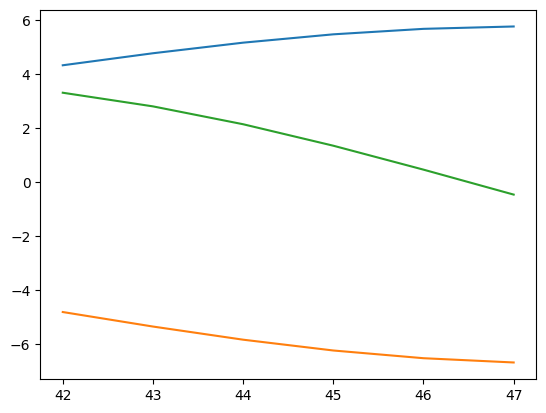

In [21]:
plt.plot(A[:, 46, :])

In [12]:
np.where(A != 0)

(array([ 0,  0,  0, ..., 47, 47, 47]),
 array([   0,    0,    0, ..., 1023, 1023, 1023]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [13]:
wf_arr=model_obj.visualize_shape(306, 30)

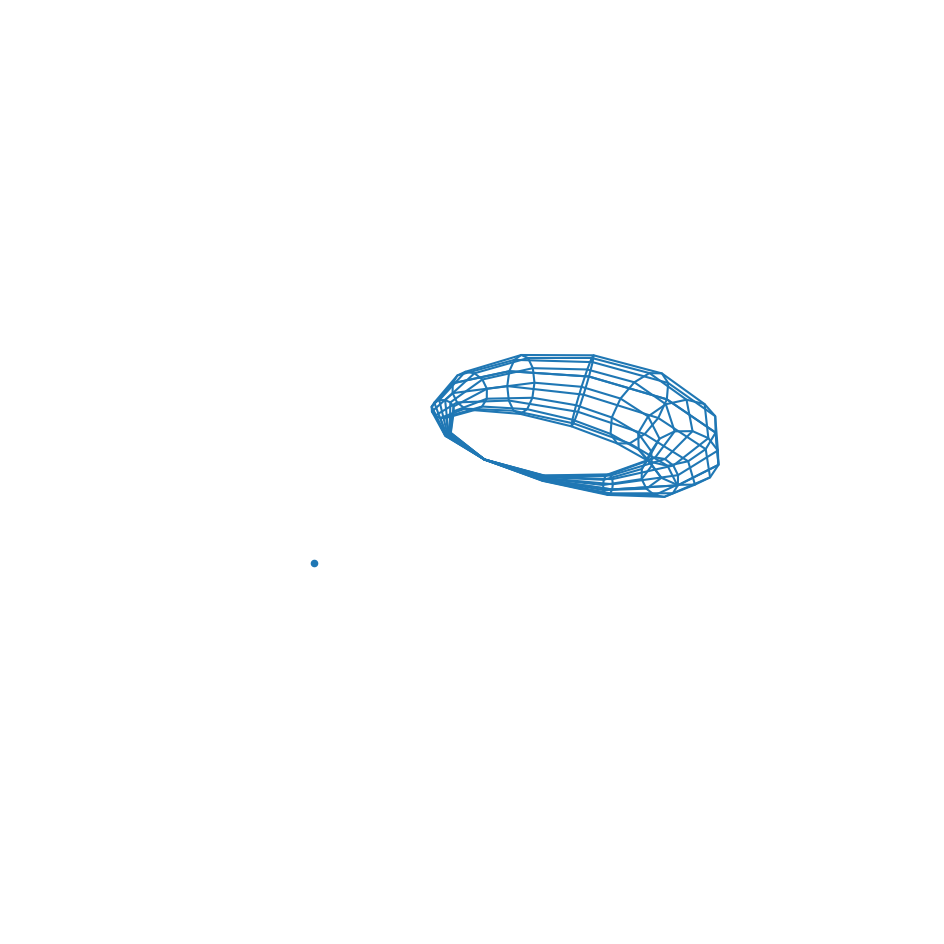

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(*wf_arr.T)
ax.scatter(1,0,0)
ax.set_axis_off()
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(elev=25, azim=35)